In [12]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc
)
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cargar los archivos CSV de entrenamiento y test
df_train = pd.read_csv('cars_cleaned.csv', delimiter=',')
df_test = pd.read_csv('cars_input_cleaned.csv', delimiter=',')

# 2. Eliminar las columnas innecesarias del conjunto de entrenamiento
df_train = df_train.drop(columns=['CODE', 'PRODUCTO', 'TIPO_CARROCERIA', 'COMBUSTIBLE', 'EDAD_COCHE', 'Tiempo'])

# 3. Imputar valores faltantes
df_train.fillna("Missing", inplace=True)
df_test.fillna("Missing", inplace=True)


In [13]:
# 4. Identificar las columnas categóricas en el conjunto de entrenamiento
categorical_columns = df_train.select_dtypes(include=['object']).columns

# 5. Convertir columnas categóricas a numéricas en ambos datasets usando LabelEncoder
label_encoder = LabelEncoder()

for column in categorical_columns:
    df_train[column] = label_encoder.fit_transform(df_train[column])
    if column in df_test.columns:
        df_test[column] = df_test[column].apply(lambda x: x if x in label_encoder.classes_ else "Missing")
        df_test[column] = label_encoder.transform(df_test[column])


In [14]:
# 6. Separar las características (X) y la variable objetivo (y) en el conjunto de entrenamiento
X_train = df_train.drop(columns=['Mas_1_coche'])
y_train = df_train['Mas_1_coche']

# 7. Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 8. Crear y entrenar el modelo XGBoost con los datos de entrenamiento
model = xgb.XGBClassifier()
model.fit(X_train_split, y_train_split)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
# 9. Guardar el modelo entrenado en un archivo .pkl
with open('xgb2_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# 10. Cargar el modelo desde el archivo .pkl
with open('xgb2_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)


In [16]:
# 11. Realizar predicciones en el conjunto de validación con el modelo cargado
y_val_pred = loaded_model.predict(X_val)

# 12. Calcular métricas de rendimiento
accuracy = accuracy_score(y_val, y_val_pred)
class_report = classification_report(y_val, y_val_pred, target_names=label_encoder.classes_)
conf_matrix = confusion_matrix(y_val, y_val_pred)


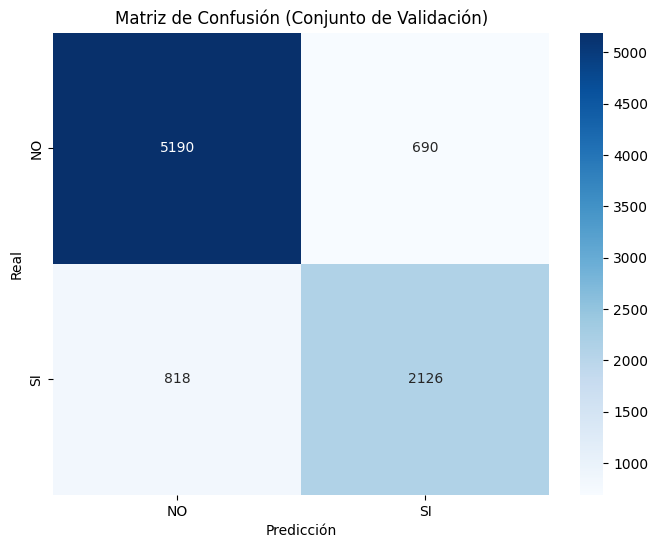

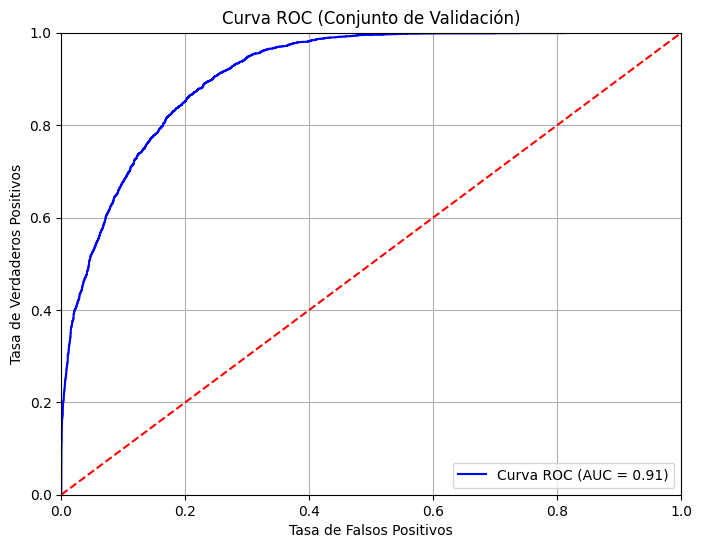

In [17]:
# 13. Calcular probabilidades para la curva ROC
y_val_proba = loaded_model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
roc_auc = auc(fpr, tpr)

# 14. Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión (Conjunto de Validación)')
plt.show()

# 15. Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC (Conjunto de Validación)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [18]:
# 20. Mostrar resultados del conjunto de validación
print(f"Precisión en el conjunto de validación: {accuracy:.2f}")
print("Reporte de Clasificación en el conjunto de validación:")
print(class_report)


Precisión en el conjunto de validación: 0.83
Reporte de Clasificación en el conjunto de validación:
              precision    recall  f1-score   support

          NO       0.86      0.88      0.87      5880
          SI       0.75      0.72      0.74      2944

    accuracy                           0.83      8824
   macro avg       0.81      0.80      0.81      8824
weighted avg       0.83      0.83      0.83      8824



In [19]:
# 8. Definir el esquema de validación cruzada con 5 folds estratificados
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 9. Realizar validación cruzada y calcular las puntuaciones (accuracy en este caso)
cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')

# 10. Mostrar las puntuaciones de cada fold y el promedio
print("Puntuaciones de validación cruzada (Accuracy) por fold:")
print(cv_scores)
print(f"\nPrecisión promedio de validación cruzada: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")



Puntuaciones de validación cruzada (Accuracy) por fold:
[0.82524932 0.81731641 0.82762919 0.81992294 0.82568287]

Precisión promedio de validación cruzada: 0.82 ± 0.00


In [20]:
# 16. Asegurarse de que las columnas de test sean las mismas que las de entrenamiento
X_test = df_test[X_train.columns]

# 17. Realizar predicciones en el conjunto de test con el modelo cargado
y_test_pred = loaded_model.predict(X_test)

# 18. Guardar las predicciones junto con el conjunto de test original
df_test['Mas_1_coche'] = y_test_pred

# 19. Guardar el resultado en un archivo CSV
df_test.to_csv('cars_test2_pred_mod.csv', index=False)
print("Predicciones guardadas en 'cars_test_pred_mod.csv'.")


Predicciones guardadas en 'cars_test_pred_mod.csv'.


In [21]:
# 16. Asegurarse de que las columnas de test sean las mismas que las de entrenamiento
X_test = df_test[X_train.columns]

# 17. Realizar predicciones en el conjunto de test con el modelo cargado
y_test_pred = loaded_model.predict(X_test)

# 18. Obtener las probabilidades de predicción para la clase 1
y_test_proba = loaded_model.predict_proba(X_test)[:, 1]  # La probabilidad de la clase "1"

# 19. Guardar las predicciones junto con las probabilidades en el conjunto de test
df_test['Mas_1_coche'] = y_test_pred
df_test['Probabilidad_Mas_1_coche'] = y_test_proba  # Agregar la columna con las probabilidades

# 20. Guardar el resultado en un archivo CSV
df_test.to_csv('cars_test_pred_mod_con_probabilidad.csv', index=False)
print("Predicciones y probabilidades guardadas en 'cars_test_pred_mod_con_probabilidad.csv'.")


Predicciones y probabilidades guardadas en 'cars_test_pred_mod_con_probabilidad.csv'.
